In [1]:
import numpy as np
import scipy.stats as stats
import scipy.special as special
import pandas as pd
import chaospy as cp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns

sns.set_style("ticks")#'whitegrid')#
#sns.set_context("talk")
sns.set_style({'axes.linewidth':0.5,
               'xtick.direction': u'in',
               'xtick.major.size': 1.,
               'xtick.minor.size': 0.5,
               'ytick.direction': u'in',               
               'ytick.major.size': 1.,
               'ytick.minor.size': 0.5})  


:0: FutureWarning: IPython widgets are experimental and may change in the future.


# 3) Multivariate Normal

Model:

$ u = I\,e^{-a\,x} $ 

In [2]:
def u(x,a,I):
    return I*np.exp(-a*x)

x = np.linspace(0,10,101)

with uncertain inputs: $a$ and $I$

In [3]:
mu = [.8,8.] 
C = [[.01,.1],[.1,2.]]

dist_Q = cp.MvNormal(mu,C)
# Uncorrelated Standard Normals
dist_R = cp.J(cp.Normal(), cp.Normal())
# Cholesky decomposition: C=np.dot(L.T,L)
L = np.linalg.cholesky(C) 
# Transfromation to Standard Normal
def tr(r):
    return np.dot(L,r) + np.reshape(mu,[2,1])

### a) Full MC with Halton sampling

In [4]:
sample_inputs = dist_Q.sample(size=1000,rule='H')
sample_u = np.array([u(x,*node) for node in sample_inputs.T])

E_u = np.mean(sample_u,axis=0)
Std_u = np.std(sample_u,axis=0)
Q05_u = np.percentile(sample_u,5,axis=0)
Q95_u = np.percentile(sample_u,95,axis=0)

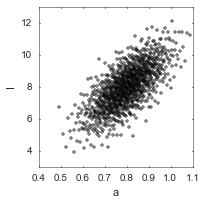

In [5]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(sample_inputs[0,:],sample_inputs[1,:],'.k',alpha=0.5)
ax.set_xlabel('a')
ax.set_ylabel('I')

fig.tight_layout()
#fig.savefig('Figures/3_MultiNormal_MC_sample.pdf')
print

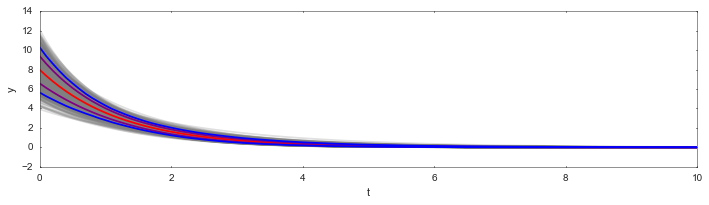

In [6]:
fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)

ax.plot(x,sample_u.T,'grey',alpha=0.25)
ax.plot(x,E_u,'r')
ax.plot(x,E_u+Std_u,'purple')
ax.plot(x,E_u-Std_u,'purple')
ax.plot(x,Q05_u,'blue')
ax.plot(x,Q95_u,'blue')

ax.set_xlabel('t')
ax.set_ylabel('y')

fig.tight_layout()
fig.savefig('Figures/3_MultiNormal_MC.pdf')
print

### b) PCE with Point collocation: Least squares

In [109]:
D = 2     # Number of dimensions
M = 3     # Order of the polynomial
N = M + 1 # Number of terms

In [110]:
P = cp.orth_ttr(M,dist_R)
# Hammersley sampling proved to be optimally stable [Hosder]=ref(at)Chaospy[31]
# Exponenial rule 
nodes_R = dist_R.sample(3*special.comb(D+M-1,M-1),rule='M') 
nodes_Q = dist_Q.inv(dist_R.fwd(nodes_R))#tr(nodes_R)
sample_u_pc = np.array([u(x,*node) for node in nodes_Q.T])

print len(P)

u_hat = cp.fit_regression(P, nodes_R, sample_u_pc)#, rule='LA', n_nonzero_coefs=20, eps=1e-3)

10


18


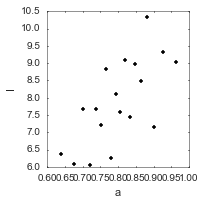

In [111]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)

ax.plot(nodes_Q[0,:],nodes_Q[1,:],'.k')

ax.set_xlabel('a')
ax.set_ylabel('I')

fig.tight_layout()
fig.savefig('Figures/3_MultiNormal_PCE_sample.pdf')
print len(nodes_Q[0,:])

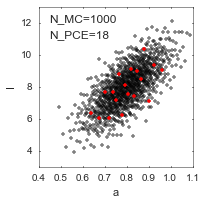

In [112]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(sample_inputs[0,:],sample_inputs[1,:],'.k',alpha=0.5)
ax.plot(nodes_Q[0,:],nodes_Q[1,:],'.r')
ax.set_xlabel('a')
ax.set_ylabel('I')

ax.text(0.45,12,'N_MC='+str(len(sample_inputs[0,:])))
ax.text(0.45,11,'N_PCE='+str(len(nodes_Q[0,:])))

fig.tight_layout()
fig.savefig('Figures/3_MultiNormal_MC_sample.pdf')
print

In [113]:
print u_hat[0]

q1+2.26129318321e-15q0q1^2+8.0+8.32667268469e-17q0^3+8.74300631892e-16q0^2q1-2.48954632521e-15q1^2-5.98815349294e-15q0^2+q0-7.97340653262e-16q1^3+6.44413580761e-16q0q1


In [114]:
mean_u_pc, std_u_pc = cp.E(u_hat, dist_R), cp.Std(u_hat, dist_R)
# Repeat the MC sample ussing the surrogate model
sample_tr_inputs = dist_R.sample(size=1000,rule='H')
sample_u_hat = np.array([u_hat(*in_vars) for in_vars in sample_tr_inputs.T ])

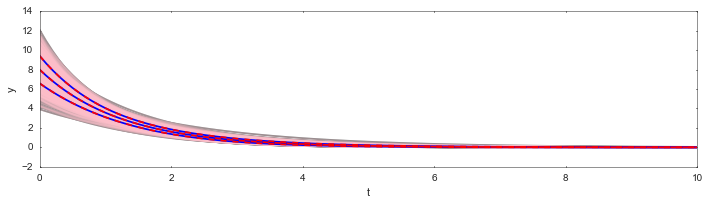

In [115]:
fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)

ax.plot(x,sample_u.T,'grey')
ax.plot(x,sample_u_hat.T,'pink',alpha=0.25)

ax.plot(x,E_u,'blue')
ax.plot(x,E_u+Std_u,'blue')
ax.plot(x,E_u-Std_u,'blue')

ax.plot(x,mean_u_pc,'--r')
ax.plot(x,mean_u_pc+std_u_pc,'--r')
ax.plot(x,mean_u_pc-std_u_pc,'--r')

ax.set_xlabel('t')
ax.set_ylabel('y')

fig.tight_layout()
fig.savefig('Figures/3_MultiNormal_top.pdf')
print

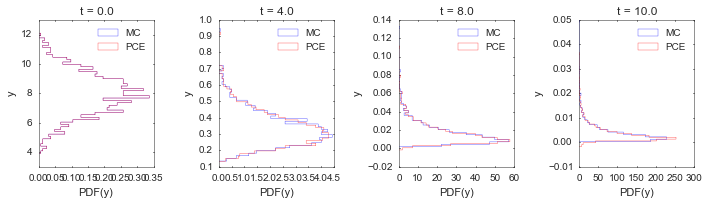

In [116]:
fig = plt.figure(figsize=[10,3])

for i,x_ref in enumerate([0., 4., 8., 10.]):
    ax = fig.add_subplot(1,4,i+1)
    ax.hist(sample_u[:,np.where(x==x_ref)[0]],
             bins=50,#np.linspace(-0.2,.2,50),
             histtype='step',
             color='blue',
             normed=True,
             cumulative=False,
             label='MC',
             orientation=u'horizontal',
            )

    ax.hist(sample_u_hat[:,np.where(x==x_ref)[0]],
             bins=50,#np.linspace(-0.2,.2,50),
             histtype='step',
             color='red',
             normed=True,
             cumulative=False,
             label='PCE',
             orientation=u'horizontal',
            )

    ax.set_ylabel('y')
    ax.set_xlabel('PDF(y)')
    ax.set_title('t = '+str(x_ref))
    ax.legend(loc='upper right')

fig.tight_layout()
fig.savefig('Figures/3_MultiNormal_bot.pdf')
print

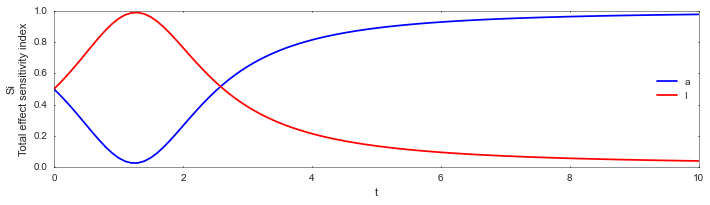

In [117]:
Sensitivity = cp.Sens_t(u_hat, dist_R)

fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)
ax.plot(x,Sensitivity[0,:],'blue',label='a')
ax.plot(x,Sensitivity[1,:],'red',label='I')
ax.legend(loc='center right')

ax.set_xlabel('t')
ax.set_ylabel('Si\nTotal effect sensitivity index')

fig.tight_layout()
fig.savefig('Figures/3_MultiNormal_Sens.pdf')


### c) PCE with Semi-spectral projection

25


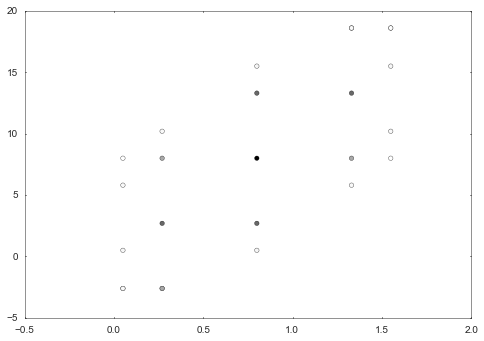

In [118]:
M = 3
P = cp.orth_ttr(M,dist_R)
nodes_R, weights_R = cp.generate_quadrature(M+1, dist_R)
nodes_Q = dist_Q.inv(dist_R.fwd(nodes_R)) #tr(nodes_R)  #
#weights_Q = weights_R*dist_Q.pdf(nodes_Q)/dist_R.pdf(nodes_R)

sample_u_pc = [u(x,*node) for node in nodes_Q.T]
u_hat = cp.fit_quadrature(P, nodes_R, weights_R, sample_u_pc)
plt.scatter(nodes_Q[0,:],nodes_Q[1,:],c=weights_R)
print len(weights_R)

In [119]:
mean_u_pc, std_u_pc = cp.E(u_hat, dist_R), cp.Std(u_hat, dist_R)
# Repeat the MC sample ussing the surrogate model
sample_tr_inputs = dist_R.sample(size=1000,rule='H')
sample_u_hat = np.array([u_hat(*in_vars) for in_vars in sample_tr_inputs.T ])

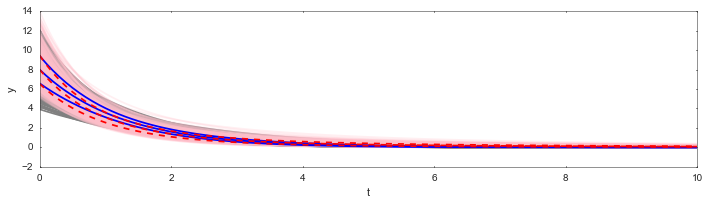

In [120]:
fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)

ax.plot(x,sample_u.T,'grey')
ax.plot(x,sample_u_hat.T,'pink',alpha=0.25)

ax.plot(x,E_u,'blue')
ax.plot(x,E_u+Std_u,'blue')
ax.plot(x,E_u-Std_u,'blue')

ax.plot(x,mean_u_pc,'--r')
ax.plot(x,mean_u_pc+std_u_pc,'--r')
ax.plot(x,mean_u_pc-std_u_pc,'--r')

ax.set_xlabel('t')
ax.set_ylabel('y')

fig.tight_layout()

print

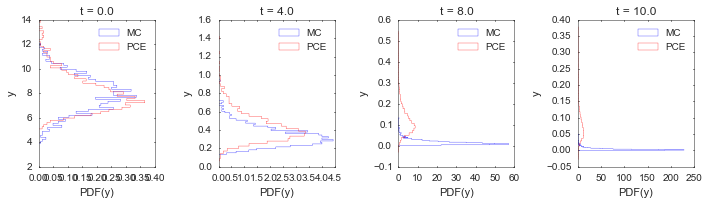

In [121]:
fig = plt.figure(figsize=[10,3])

for i,x_ref in enumerate([0., 4., 8., 10.]):
    ax = fig.add_subplot(1,4,i+1)
    ax.hist(sample_u[:,np.where(x==x_ref)[0]],
             bins=50,#np.linspace(-0.2,.2,50),
             histtype='step',
             color='blue',
             normed=True,
             cumulative=False,
             label='MC',
             orientation=u'horizontal',
            )

    ax.hist(sample_u_hat[:,np.where(x==x_ref)[0]],
             bins=50,#np.linspace(-0.2,.2,50),
             histtype='step',
             color='red',
             normed=True,
             cumulative=False,
             label='PCE',
             orientation=u'horizontal',
            )

    ax.set_ylabel('y')
    ax.set_xlabel('PDF(y)')
    ax.set_title('t = '+str(x_ref))
    ax.legend(loc='upper right')
    fig.tight_layout()
print

### d) Conclusion

PCE with spectral collocation does not work for correlated variables, becuase the correlation is NOT considered in the quadrature rule. 

PCE with point collocation and a simple least square polynomial fit DOES work. 

### e) Convergence

```python
sample_inputs = dist_Q.sample(size=10**6,rule='H')
sample_u = np.array([u(x,*node) for node in sample_inputs.T])

E_u = np.mean(sample_u,axis=0)
Std_u = np.std(sample_u,axis=0)
```

In [122]:
D = 2    # Number of dimensions
M = 8    # Order of the polynomial
P = cp.orth_ttr(M, dist_R)
Npc = 3*special.comb(D+M-1,M-1) #2**M-1#
print 3*special.comb(D+M-1,M-1), 2**M-1
nodes_R = dist_R.sample(Npc,rule='M') 
nodes_Q = dist_Q.inv(dist_R.fwd(nodes_R))
sample_u_pc = np.array([u(x,*node) for node in nodes_Q.T])
u_hat = cp.fit_regression(P, nodes_R, sample_u_pc)
E_u, Std_u = cp.E(u_hat, dist_R), cp.Std(u_hat, dist_R)

108.0 255


In [123]:
def PCE(M):
    # M: Order of the polynomial
    D = 2    # Number of dimensions
    
    P = cp.orth_ttr(M,dist_R)
    # Hammersley sampling proved to be optimally stable [Hosder]=ref(at)Chaospy[31]
    # Exponenial rule 
    Npc = 3*special.comb(D+M-1,M-1) #2**M-1
    nodes_R = dist_R.sample(Npc,rule='M') 
    nodes_Q = dist_Q.inv(dist_R.fwd(nodes_R))
    sample_u_pc = np.array([u(x,*node) for node in nodes_Q.T])

    print Npc #len(P)

    u_hat = cp.fit_regression(P, nodes_R, sample_u_pc)#, rule='LL', alpha=1e-6, max_iter=300) 
    
    mean_u_pc, std_u_pc = cp.E(u_hat, dist_R), cp.Std(u_hat, dist_R)
    
    
    Error_E = np.trapz(np.abs(E_u - mean_u_pc)/E_u,x)/10.
    Error_Std = np.trapz(np.abs(std_u_pc**2./Std_u**2. - 1.),x)/10.  
    
    return Npc,Error_E, Error_Std

In [124]:
order = range(2,8)
Npc     = np.zeros(len(order))
Error_E = np.zeros(len(order))
Error_Std = np.zeros(len(order))

for i,M in enumerate(order):
    Npc[i],Error_E[i], Error_Std[i] = PCE(M)

9.0
18.0
30.0
45.0
63.0
84.0


In [125]:
def MC(Nmc):
    sample_inputs = dist_Q.sample(size=Nmc,rule='H')
    sample_u = np.array([u(x,*node) for node in sample_inputs.T])

    E_u_mc = np.mean(sample_u,axis=0)
    Std_u_mc = np.std(sample_u,axis=0)
    
    Error_E_mc = np.trapz(np.abs(E_u - E_u_mc)/E_u,x)/10.
    Error_Std_mc = np.trapz(np.abs(Std_u_mc**2./Std_u**2.-1.),x)/10.
    
    return Error_E_mc, Error_Std_mc

In [128]:
Nmc     = [10,10**2,10**3,10**4,10**5]
Error_E_mc = np.zeros(len(Nmc))
Error_Std_mc = np.zeros(len(Nmc))

for i,N in enumerate(Nmc):
    Error_E_mc[i], Error_Std_mc[i] = MC(N)

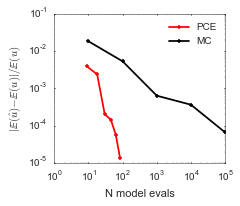

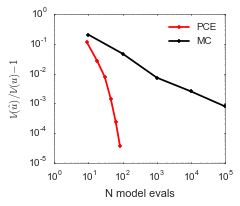

In [129]:
output_name_label = 'u'

fig = plt.figure(figsize=[3.5,3])
ax = fig.add_subplot(111)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim([1e-6,1e0])
ax.plot(Npc,Error_E,'.-r',label='PCE')
ax.plot(Nmc,Error_E_mc,'.-k',label='MC')
ax.set_xlabel('N model evals')
ax.set_ylabel(r'$|\mathbb{E}(\hat{'+output_name_label+'})-\mathbb{E}('+output_name_label+')|/\mathbb{E}('+output_name_label+')$')
ax.legend(loc='best')
fig.tight_layout()
fig.savefig('Figures/3_Convergence_E_'+output_name_label+'.pdf')


fig = plt.figure(figsize=[3.5,3])
ax = fig.add_subplot(111)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim([1e-4,1e0])
ax.plot(Npc,Error_Std,'.-r',label='PCE')
ax.plot(Nmc,Error_Std_mc,'.-k',label='MC')
ax.set_xlabel('N model evals')
ax.set_ylabel(r'$\mathbb{V}(\hat{'+output_name_label+'})/\mathbb{V}('+output_name_label+') -1$')
ax.legend(loc='best')
fig.tight_layout()
fig.savefig('Figures/3_Convergence_V_'+output_name_label+'.pdf')